# Import Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

2025-08-12 12:21:56.836234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755001317.061668      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755001317.118257      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Configuration

In [2]:
TIME_STEPS = 187 # Length of each ECG Signal
N_CLASSES = 5    # Classes: 0=Normal | 1-4=Anomalies
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 150

# Download and Load Dataset

In [3]:
def load_dataset():
    # from google.colab import userdata
    # import os
    # os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
    # os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

    # # Download dataset from kaggle
    # !kaggle datasets download -d shayanfazeli/heartbeat
    # !unzip heartbeat.zip

    # Load train/test data
    train_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
    test_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)

    return train_df, test_df

# Call func
train_df, test_df = load_dataset()

**Check DataFrames**

In [4]:
train_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
test_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train_df.iloc[:, -1].value_counts()

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

# Analyze Data

Signal Length: 187


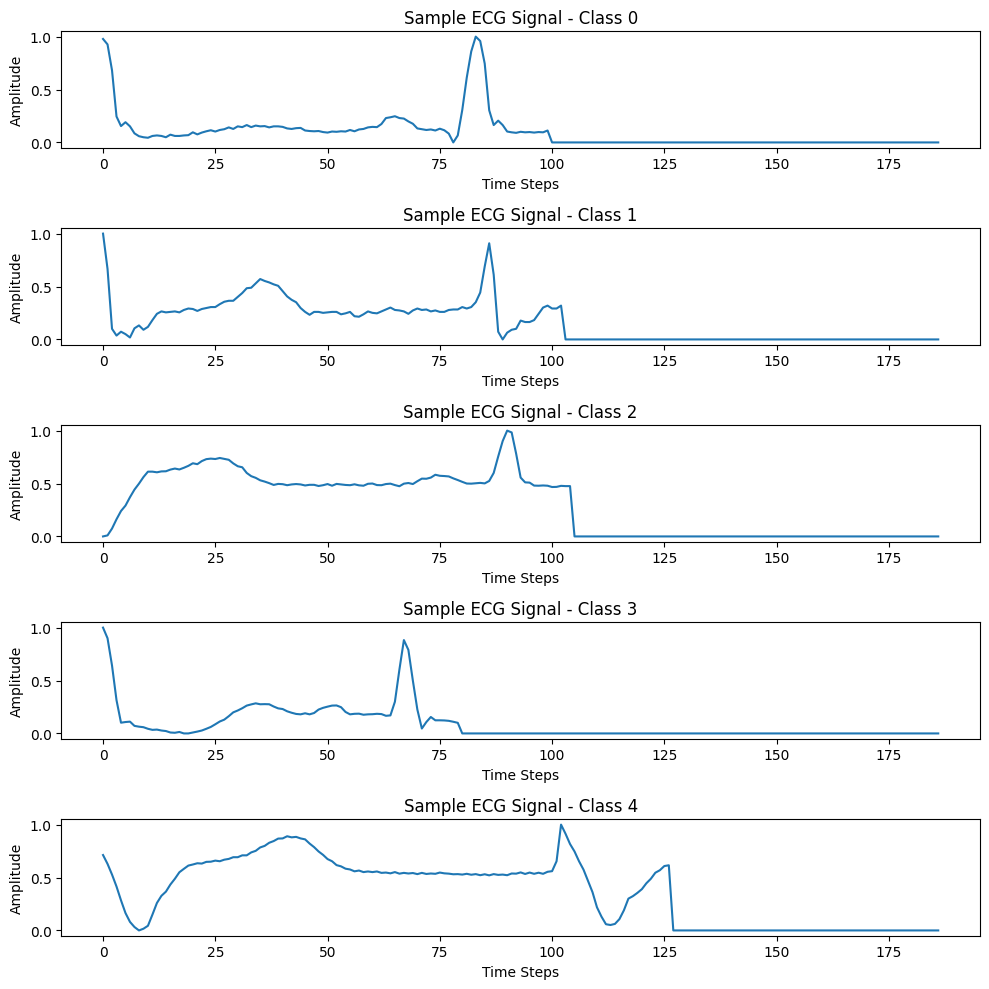

In [7]:
def analyze_data(df):
    signal_length = df.shape[1] - 1
    print(f"Signal Length: {signal_length}")

    if not set(df.iloc[:, -1].unique()).issubset({0, 1, 2, 3, 4}):
        print("Warning: Invalid class labels found!")
        print("Unique classes:", df.iloc[:, -1].unique())

    plt.figure(figsize=(10, 10))
    for class_idx in range(N_CLASSES):
        class_data = df[df.iloc[:, -1] == class_idx]
        if not class_data.empty:
            sample = class_data.iloc[0, :-1]
            plt.subplot(N_CLASSES, 1, class_idx + 1)
            plt.plot(sample)
            plt.title(f'Sample ECG Signal - Class {class_idx}')
            plt.xlabel('Time Steps')
            plt.ylabel('Amplitude')
        else:
            print(f"No samples found for class {class_idx}")
    plt.tight_layout()
    plt.show()

analyze_data(train_df)

Signal Length: 187


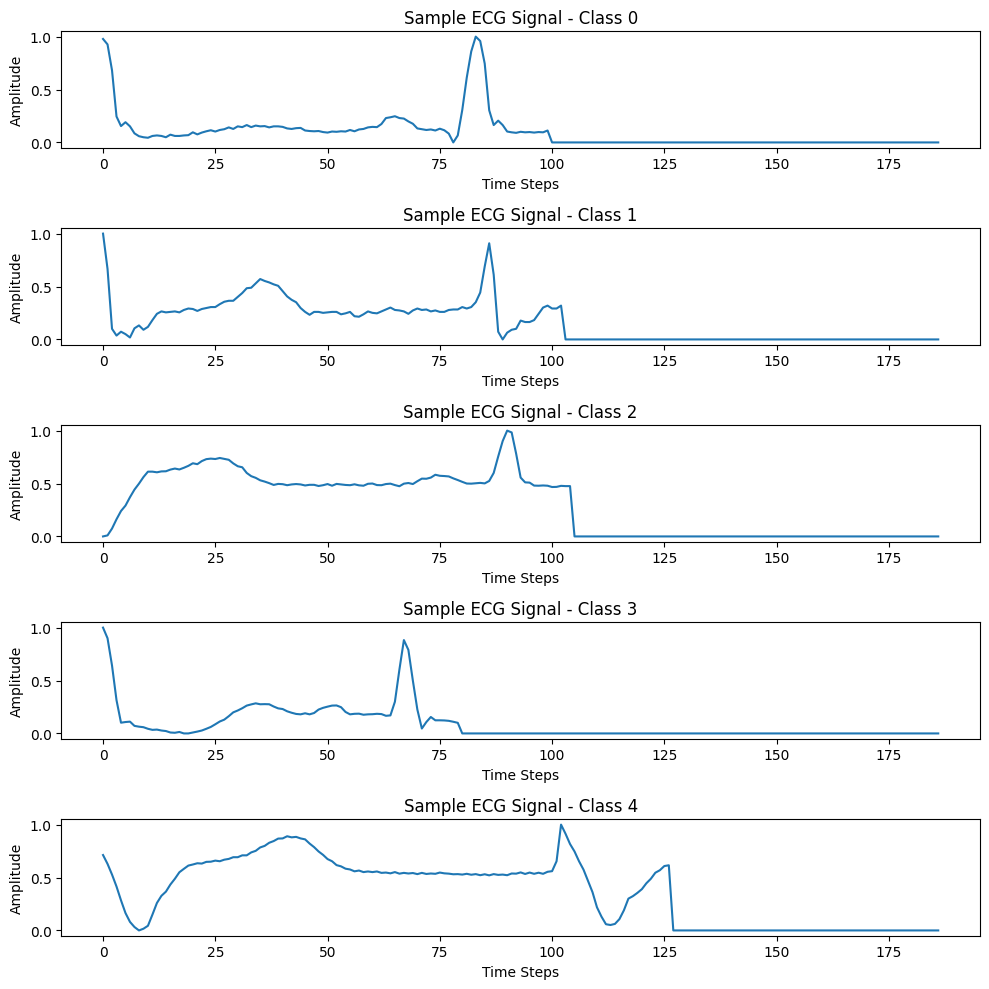

In [8]:
# Call func
# Train dataframe
analyze_data(train_df)

Signal Length: 187


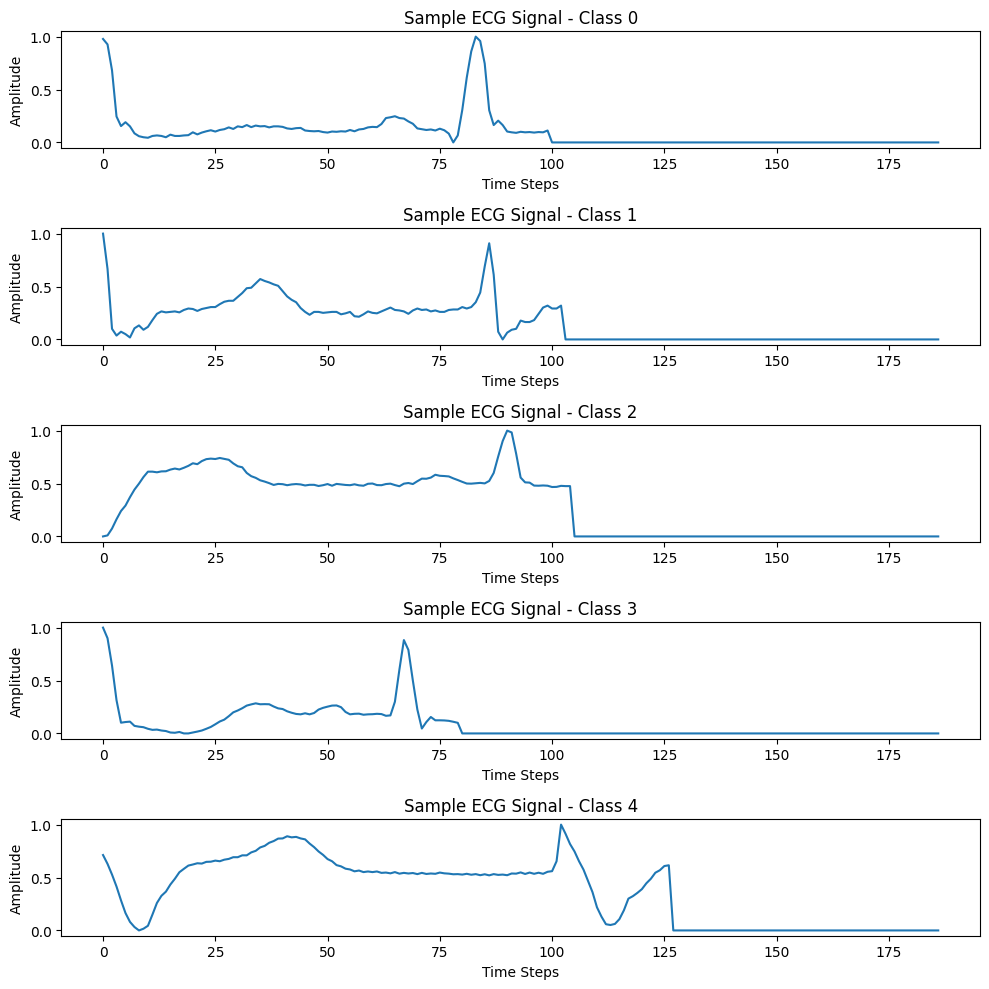

In [9]:
# Call func
# Test dataframe
analyze_data(train_df)

# Preprocess Data

In [10]:
def preprocess_data(df, time_steps, n_classes, scaler=None):
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values.astype(int)

    if X.shape[1] != time_steps:
        raise ValueError(f"Expected signal length {time_steps}, but got {X.shape[1]}")

    if scaler is None:
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    X_scaled = X_scaled.reshape((X_scaled.shape[0], time_steps, 1))
    y_onehot = to_categorical(y, num_classes=n_classes)

    return X_scaled, y_onehot, scaler

X_train, y_train, scaler = preprocess_data(train_df, TIME_STEPS, N_CLASSES)
X_test, y_test, _ = preprocess_data(test_df, TIME_STEPS, N_CLASSES, scaler=scaler)

# Prepare Data

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VALIDATION_SPLIT, random_state=42, stratify=y_train
)

print(f"X_train Shape: {X_train.shape}\t|\t y_train Shape: {y_train.shape}")
print(f"X_val Shape: {X_val.shape}\t|\t y_val Shape: {y_val.shape}")
print(f"X_test Shape: {X_test.shape}\t|\t y_test Shape: {y_test.shape}")

X_train Shape: (70043, 187, 1)	|	 y_train Shape: (70043, 5)
X_val Shape: (17511, 187, 1)	|	 y_val Shape: (17511, 5)
X_test Shape: (21892, 187, 1)	|	 y_test Shape: (21892, 5)


# Define LSTM Model

In [12]:
def build_model(time_steps, n_features=1, n_classes=5):
    # Define layers
    inputs = Input(shape=(time_steps, n_features))
    x = GRU(units=256, activation='tanh', return_sequences=True)(inputs)
    x = Dropout(0.4)(x)
    x = GRU(units=128, activation='tanh', return_sequences=True)(x)
    x = Dropout(0.4)(x)
    x = GRU(units=64, activation='tanh', return_sequences=True)(x)
    x = Dropout(0.4)(x)
    x = GRU(units=32, activation='tanh', return_sequences=False)(x)
    x = Dropout(0.4)(x)
    x = Dense(units=32, activation="relu")(x)

    # Output layer
    outputs = Dense(n_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

# Create model
model = build_model(TIME_STEPS, 1, N_CLASSES)
model.summary()

I0000 00:00:1755001341.913495      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755001341.914153      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 187, 256)       │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 187, 128)       │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 187, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 187, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,013 (1.51 MB)

 Trainable params: 395,013 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [13]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_ecg_model.keras",
    monitor="val_loss",
    save_best_only=True
)

# Class weights
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced',
                                     classes=np.arange(N_CLASSES),
                                     y=y_train_labels)
class_weights = dict(enumerate(class_weights))

# Train
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint],
    class_weight=class_weights
)

Epoch 1/150


I0000 00:00:1755001348.797531      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


2189/2189 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - accuracy: 0.0622 - loss: 1.6052 - val_accuracy: 0.0344 - val_loss: 1.6407
Epoch 2/150
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 68s 31ms/step - accuracy: 0.1134 - loss: 1.4947 - val_accuracy: 0.1003 - val_loss: 1.6369
Epoch 3/150
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 69s 31ms/step - accuracy: 0.1913 - loss: 1.2799 - val_accuracy: 0.2071 - val_loss: 1.5723
Epoch 4/150
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 69s 31ms/step - accuracy: 0.2580 - loss: 1.2503 - val_accuracy: 0.2774 - val_loss: 1.4480
Epoch 5/150
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 68s 31ms/step - accuracy: 0.2919 - loss: 1.2444 - val_accuracy: 0.2651 - val_loss: 1.4842
Epoch 6/150
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 69s 31ms/step - accuracy: 0.2997 - loss: 1.2369 - val_accuracy: 0.3246 - val_loss: 1.4720
Epoch 7/150
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 69s 31ms/step - accuracy: 0.3226 - loss: 1.2028 - val_accuracy: 0.3385 - val_loss: 1.3869
Epoch 8/150
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 69s 31ms/step - accuracy: 0.3455 - los

# Visualizing Training Progress

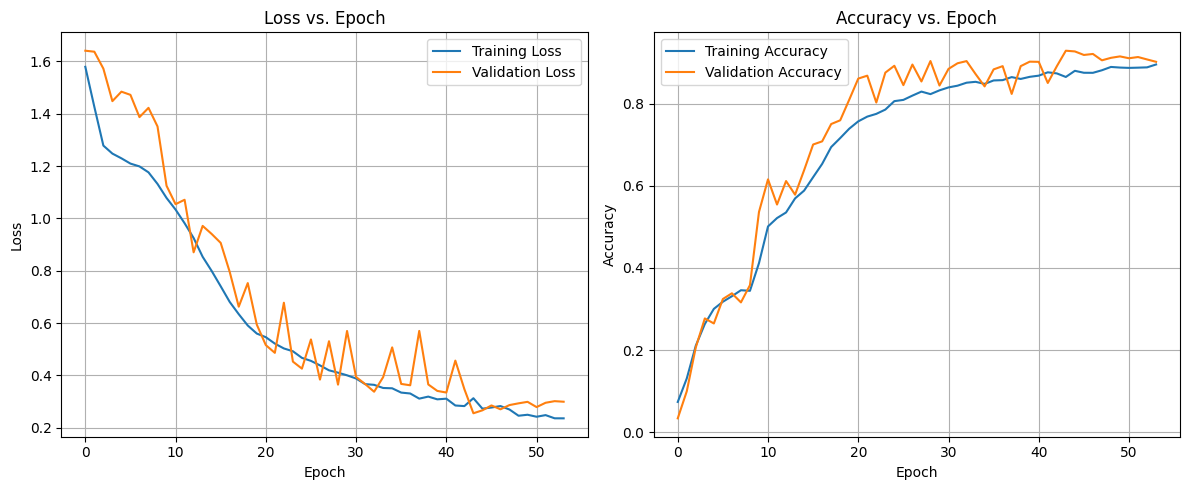

In [14]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate Model

685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step

Test Loss: 0.2625
Test Accuracy: 0.9248
Test F1-Score (Weighted): 0.9367
Predicted class distribution: [16998  1286  1538   485  1585]


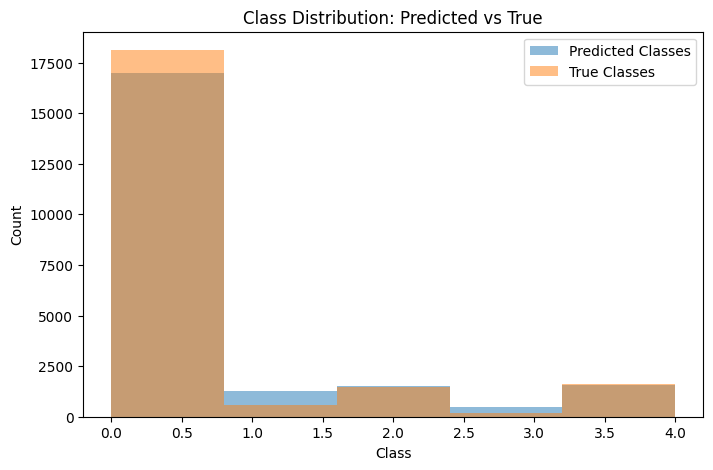

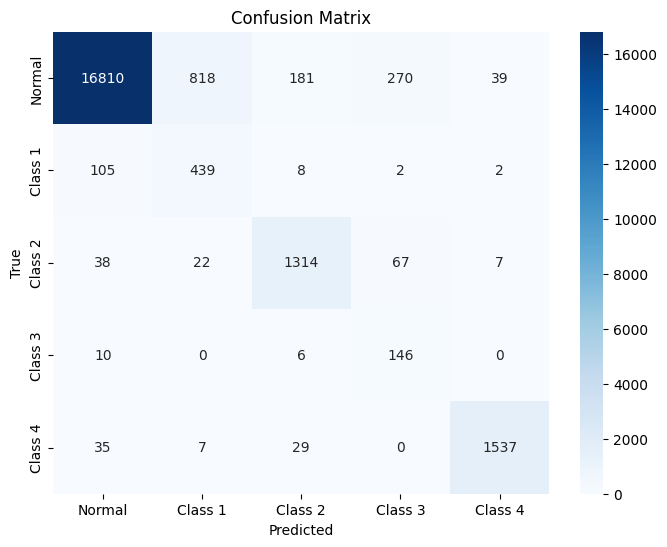

In [15]:
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    
    print("\nTest Loss: {:.4f}".format(test_loss))
    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("Test F1-Score (Weighted): {:.4f}".format(f1))
    print("Predicted class distribution:", np.bincount(y_pred_classes))
    
    plt.figure(figsize=(8, 5))
    plt.hist(y_pred_classes, bins=5, label='Predicted Classes', alpha=0.5)
    plt.hist(y_test_classes, bins=5, label='True Classes', alpha=0.5)
    plt.title('Class Distribution: Predicted vs True')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
    
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], 
                yticklabels=['Normal', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return y_pred_classes, y_test_classes

y_pred_classes, y_test_classes = evaluate_model(model, X_test, y_test)

In [16]:
def predict_signal(model, signal, scaler, time_steps):
    signal_scaled = scaler.transform(signal.reshape(1, -1))
    signal_scaled = signal_scaled.reshape(1, time_steps, 1)
    pred = model.predict(signal_scaled)
    pred_class = np.argmax(pred, axis=1)[0]
    class_names = {0: 'Normal', 1: 'Class 1 (Anomaly)', 2: 'Class 2 (Anomaly)', 
                   3: 'Class 3 (Anomaly)', 4: 'Class 4 (Anomaly)'}
    return class_names[pred_class]

# Test prediction on multiple samples
for i in range(min(5, len(test_df))):
    sample_signal = test_df.iloc[i, :-1].values
    true_label = test_df.iloc[i, 187]
    print(f"Sample {i} Prediction: {predict_signal(model, sample_signal, scaler, TIME_STEPS)}, True Label: {true_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Sample 0 Prediction: Normal, True Label: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sample 1 Prediction: Normal, True Label: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sample 2 Prediction: Normal, True Label: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sample 3 Prediction: Normal, True Label: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sample 4 Prediction: Normal, True Label: 0.0
